In [1]:
from config import POSTGRES_CONNECTION_STRING
import pandas as pd
from sqlalchemy import create_engine
import plotly.express as px
import math
import ipyleaflet as lft
from ipywidgets import Layout, HTML
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import haversine as hs

In [2]:
MAPBOX_TOKEN = 'pk.eyJ1IjoicmVzaXZhbGV4IiwiYSI6ImNrdGxvbzgxaTBpcjIydm1qeGVxeXN5YTUifQ.hcWyP3yOX2jg0NHiTjg9Fg'
px.set_mapbox_access_token(MAPBOX_TOKEN)

In [3]:
def con():
    return create_engine(POSTGRES_CONNECTION_STRING)

In [4]:
data = pd.read_sql_query('''
    select *
    from districts
''', con())
data.head()

,id,district,division,square,population,lat,lng
0,1,Богородское,Восточный округ,10.24,110044,55.819760,37.704231
1,2,Вешняки,Восточный округ,10.72,121972,55.730776,37.815193
2,3,Восточное,Восточный округ,3.14,13698,55.814980,37.867588
3,4,Восточное Измайлово,Восточный округ,3.85,77931,55.795818,37.821804
4,5,Гольяново,Восточный округ,14.99,162886,55.816819,37.798242


In [5]:
points = data.copy()[['district', 'division', 'square', 'population', 'lat', 'lng']]
points['radius'] = (data['square'] / math.pi) ** 0.5
points['density'] = data['population'] / data['square']
points['relative_density'] = points['density'] / points['density'].max()
points.head()

,district,division,square,population,lat,lng,radius,density,relative_density
0,Богородское,Восточный округ,10.24,110044,55.819760,37.704231,1.805407,10746.484375,0.353979
1,Вешняки,Восточный округ,10.72,121972,55.730776,37.815193,1.847236,11377.985075,0.374780
2,Восточное,Восточный округ,3.14,13698,55.814980,37.867588,0.999746,4362.420382,0.143694
3,Восточное Измайлово,Восточный округ,3.85,77931,55.795818,37.821804,1.107020,20241.818182,0.666746
4,Гольяново,Восточный округ,14.99,162886,55.816819,37.798242,2.184368,10866.310874,0.357926


In [6]:
max_density = points['density'].max()
max_density

30359.132420091326

In [7]:
MSK = [55.755819, 37.617644]

In [8]:
divisions = points.groupby('division')[['lat', 'lng']].mean()
divisions.head()

,lat,lng
division,,
Восточный округ,55.781806,37.787416
Западный округ,55.698241,37.437988
Зеленоградский округ,55.989542,37.196998
Новомосковский округ,55.563445,37.379101
Северный округ,55.842851,37.518872


In [9]:
m = lft.Map(
    center=MSK, basemap=lft.basemaps.OpenStreetMap.Mapnik, zoom=9,
    layout=Layout(width='100%', height='400px'))
for index, p in points.iterrows():
    coords = [p['lat'], p['lng']]
    c = lft.Circle(location=coords, radius=int(p['radius'] * 1000), weight=1,
                color='#04F', opacity=0, fill_opacity=(p['relative_density'] + 0.5) / 1.5,
                fill_color='#04F')
    m.add_layer(c)
m

Map(center=[55.755819, 37.617644], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

In [10]:
max_radius = points['radius'].max()
min_lat = points['lat'].min()
max_lat = points['lat'].max()
min_lng = points['lng'].min()
max_lng = points['lng'].max()
dt_lat = hs.inverse_haversine((min_lat, min_lng), max_radius, hs.Direction.NORTH)[0] - min_lat
dt_lng = hs.inverse_haversine((min_lat, min_lng), max_radius, hs.Direction.EAST)[1] - min_lng
min_lat -= dt_lat
max_lat += dt_lat
min_lng -= dt_lng
max_lng += dt_lng

In [11]:
lat_size = max_lat - min_lat
lng_size = max_lng - min_lng
width = hs.haversine((min_lat + lat_size / 2, min_lng), (min_lat + lat_size / 2, max_lng))
height = hs.haversine((min_lat, min_lng + lng_size / 2), (max_lat, min_lng + lng_size / 2))
width, height

(82.49326640833905, 103.56069349921687)

In [12]:
lng_km = width / lat_size
lat_km = height / lng_size
lng_km, lat_km

(88.57458430471831, 78.8380940085742)

In [13]:
def opt_haversine(p1, p2):
    lat_km = 78.8380940085742
    lng_km = 88.57458430471831
    hor_dt = (p2[0] - p1[0]) * lng_km
    ver_dt = (p2[1] - p1[1]) * lat_km
    return (hor_dt ** 2 + ver_dt ** 2) ** 0.5

In [14]:
pts = [
    {
        'lat': p['lat'],
        'lng': p['lng'],
        'radius': p['radius'],
        'density': p['density']
    }
    for _, p in points.iterrows()
]
def density(lat, lng):
    hits = []
    min_ratio = 1e18
    result = 0
    for p in pts:
        distance = hs.haversine((lat, lng), (p['lat'], p['lng']))
        radius = p['radius']
        density = p['density']
        ratio = distance / radius
        if ratio < min_ratio and distance - radius < 1.1:
            min_ratio = ratio
            result = density
    return result

In [15]:
def density_matrix(p1, p2, lat_n, lng_n):
    matrix = np.zeros((lat_n, lng_n))
    min_lat, min_lng = p1
    max_lat, max_lng = p2
    for i in range(lat_n):
        for j in range(lng_n):
            lat = min_lat + (max_lat - min_lat) / lat_n * (i + 0.5)
            lng = min_lng + (max_lng - min_lng) / lng_n * (j + 0.5)
            matrix[i, j] = density(lat, lng)
    return matrix

In [16]:
def precalculate_matrix_8192x8192():
    lat_size = max_lat - min_lat
    lng_size = max_lng - min_lng
    return density_matrix(
        (min_lat, min_lng),
        (max_lat, max_lng),
        2 ** 13, 2 ** 13
    )

In [17]:
def plot_density_matrix(matrix):
    plt.figure(figsize=(16, 16))
    sns.heatmap(np.log1p(matrix), vmin=0, vmax=11)
    plt.gca().invert_yaxis()
    plt.show()

In [18]:
def save_borders():
    np.save('map-borders', np.array([(min_lat, min_lng), (max_lat, max_lng)]))

In [19]:
np.load('map-borders.npy')

array([[55.1471993 , 36.75571401],
       [56.0785417 , 38.06930099]])

In [20]:
def precalculate_matrixes():
    cur_matrix = matrix
    while cur_matrix.shape[0] > 16:
        new_size = cur_matrix.shape[0] // 2
        print(new_size)
        new_matrix = np.zeros((new_size, new_size))
        for i in range(new_matrix.shape[0]):
            for j in range(new_matrix.shape[1]):
                new_matrix[i, j] = (
                    cur_matrix[i * 2, j * 2] +
                    cur_matrix[i * 2, j * 2 + 1] +
                    cur_matrix[i * 2 + 1, j * 2] +
                    cur_matrix[i * 2 + 1, j * 2 + 1]
                ) / 4
        cur_matrix = new_matrix
        np.save(f'matrix-{cur_matrix.shape[0]}', cur_matrix)

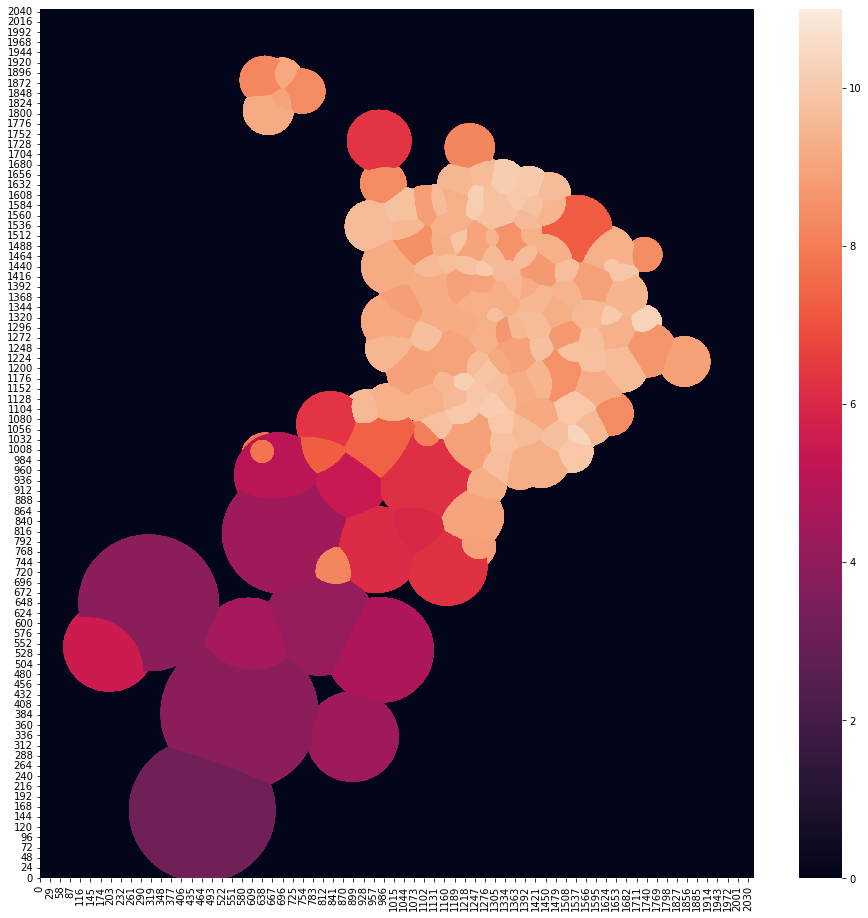

In [21]:
plot_density_matrix(np.load('matrix-2048.npy'))